# Performance of Harmonic Array
Generates performance data for the harmonic array geometry, incluing:

- SINR for two sources place a fixed distance apart (averaged across the entire stage)
- SINR metrics for the 3-source case

In [70]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import colormaps
import pyroomacoustics as pra
from pyroomacoustics.directivities import (
    DirectivityPattern,
    DirectionVector,
    CardioidFamily,
)
from scipy.io import wavfile
from playsound import playsound
from scipy.signal import resample

Simulation parameters

In [71]:
# ROOM PARAMETERS
fs = 8000 # audio sampling frequency - global (set to freq of input file)

room_x = 10 # room width
room_y = 20 # room length
stage_x = [1, 9]
stage_y = [13, 17] # x/y bounds of stage in the room
order = 0 # reflection order
sigma2_n = 5e-7 # microphone noise variance estimate
source_step = 0.1 # resolution of simulation grid (m)
v_sound = 343.0 # speed of sound in air

m = pra.make_materials(
    ceiling="hard_surface",
    floor="stage_floor",
    east="brickwork",
    west="brickwork",
    north="brickwork",
    south="brickwork",
) # materials of each surface of room, defines signal absorption when order is nonzero

# MIC ARRAY PARAMETERS
pattern = pra.DirectivityPattern.CARDIOID
orientation = pra.DirectionVector(azimuth=90, colatitude=None, degrees=True)
directivity = pra.CardioidFamily(orientation=orientation, pattern_enum=pattern)

dist_to_stage = 0.5 # design parameter for array y location
array_loc = np.array([5, stage_y[0]-dist_to_stage]) # x/y location of array - front and center of stage
n_mics = 8 # number of microphones
sep = 0.1 # microphone separation

N = 1024 # fft length - defines N/2 + 1 frequency bands

# sub-array 1: 5 mics, 10cm apart
n1 = 5 # number of microphones
sep1 = 0.1 # microphone separation
R1 = pra.linear_2D_array(center=array_loc+[0.1, 0], M=n1, phi=0, d=sep1) # sub-array is offset from center
array1 = pra.Beamformer(R1, fs, N)
f_band1 = np.array([850, fs/2])

# sub-array 2: 4 mics, 20cm apart
n2 = 4 # number of microphones
sep2 = 0.2 # microphone separation
R2 = pra.linear_2D_array(center=array_loc, M=n2, phi=0, d=sep2)
array2 = pra.Beamformer(R2, fs, N)
f_band2 = np.array([570, 850])

# sub-array 3: 5 mics, 30cm apart
n3 = 5 # number of microphones
sep3 = 0.3 # microphone separation
R3 = pra.linear_2D_array(center=array_loc, M=n3, phi=0, d=sep3)
array3 = pra.Beamformer(R3, fs, N)
f_band3 = np.array([0, 570])

# SOUND SOURCE PARAMETERS
source_x = np.arange(stage_x[0], stage_x[1]+source_step, source_step)
source_y = np.arange(stage_y[0], stage_y[1]+source_step, source_step) # Define spatial grid over which to simulate
source_filenames = ['../input_samples/singing_8000.wav', '../input_samples/german_speech_8000.wav']
_, singing = wavfile.read(source_filenames[0])
_, speech = wavfile.read(source_filenames[1])

# frequency band markers
frequencies = array1.frequencies
freq_idx1 = np.argmax(frequencies > f_band1[0])
freq_idx2 = np.argmax(frequencies > f_band2[0])
arrays = [array1, array2, array3]

### Run Simulations

Sources are placed d metres apart, at the same distance from the array.

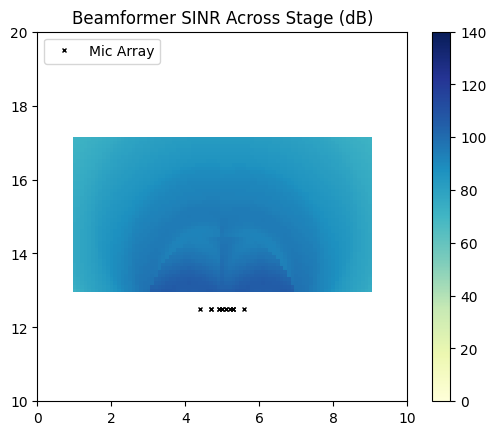

Average SINR across stage (dB):  88.16377299507751
Maximum SINR across stage (dB):  106.82333583632435
Minimum SINR across stage (dB):  71.45903705590803


In [63]:
SIRs = np.empty(shape=(len(source_x),len(source_y)))
d = 2 # source separation parameter

for i in range(len(source_x)):
    print(f'row: x = {source_x[i]}')
    for j in range(len(source_y)):

        x = source_x[i]
        y = source_y[j]

        # build room, array, and sources
        rooms = [pra.ShoeBox([room_x, room_y], fs=fs, materials=m, max_order=order, air_absorption=True, ray_tracing=False) for i in range(3)]

        s1 = [x, y] # 1st source location
        s1_mic = [x - array_loc[0], y - array_loc[1]] # location relative to array
        r = math.sqrt(s1_mic[0]**2 + s1_mic[1]**2)
        if r >= d:
                phi_rad = 2 * math.asin(d/(2*r))

                if s1_mic[0] < 0:
                    phi_rad *= -1

                s2_mic = [s1_mic[0]*math.cos(phi_rad) - s1_mic[1]*math.sin(phi_rad), s1_mic[0]*math.sin(phi_rad) + s1_mic[1]*math.cos(phi_rad)] # 2nd source location relative to array
                s2 = [s2_mic[0] + array_loc[0], s2_mic[1] + array_loc[1]]
        else:
            if s1_mic[0] < 0:
                multiplier = 1
            else:
                multiplier = -1
                
            s2 = [s1[0] + multiplier*d, s1[1]]

        source_locs = [s1, s2] # locations of each source
        for k in range(len(rooms)):
            rooms[k].add_microphone_array(arrays[k])
            rooms[k].add_source(source_locs[0], signal=singing, delay=0)
            rooms[k].add_source(source_locs[1], signal=speech, delay=0)

            # define beamformer algorithm and compute weights
            arrays[k].rake_max_sinr_weights(
                source=rooms[k].sources[0][0:1],
                interferer=rooms[k].sources[1][0:1],
                R_n=sigma2_n * np.eye(arrays[k].M)
            )

            # run simulation
            rooms[k].compute_rir()
            rooms[k].simulate()

        # compute SIR, averaged across all frequency bands
        SIR_sum = 0
        for f in arrays[0].frequencies[freq_idx1:]:
            current_SIR = arrays[0].snr(rooms[0].sources[0][0:1], rooms[0].sources[1][0:1], f, dB=True)
            if math.isnan(current_SIR) == False:
                SIR_sum += current_SIR

        for f in arrays[1].frequencies[freq_idx2:freq_idx1]:
            current_SIR = arrays[1].snr(rooms[1].sources[0][0:1], rooms[1].sources[1][0:1], f, dB=True)
            if math.isnan(current_SIR) == False:
                SIR_sum += current_SIR


        for f in arrays[2].frequencies[:freq_idx2]:
            current_SIR = arrays[2].snr(rooms[2].sources[0][0:1], rooms[2].sources[1][0:1], f, dB=True)
            if math.isnan(current_SIR) == False:
                SIR_sum += current_SIR

        SIRs[i, j] = SIR_sum / len(array1.frequencies)

# plot SIR as a function of location
y, x = np.meshgrid(source_y, source_x)
sir_min = np.min(SIRs)
sir_max = np.max(SIRs)
sir_avg = np.mean(SIRs)

fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, SIRs, cmap='YlGnBu', vmin=0, vmax=140)
ax.plot(array1.R[0], array1.R[1], 'kx', markersize=3, label="Mic Array")
ax.plot(array2.R[0], array2.R[1], 'kx', markersize=3)
ax.plot(array3.R[0], array3.R[1], 'kx', markersize=3)
ax.set_title('Beamformer SINR Across Stage (dB)')
ax.axis([0, room_x, room_y/2, room_y])
fig.gca().set_aspect('equal', adjustable='box')
fig.colorbar(c, ax=ax)
plt.legend(loc="upper left")
plt.show()

# output SIR stats
print("Average SINR across stage (dB): ", sir_avg)
print("Maximum SINR across stage (dB): ", sir_max)
print("Minimum SINR across stage (dB): ", sir_min)

### Three-source separation case

Source azimuths: [51.34019174590991, 90.0, 128.6598082540901]
Recovered azimuths: [ 53.29608939  92.51396648 129.72067039] degrees
Angular Errors: [-1.9558976395649523, -2.513966480446939, -1.0608621369713376] degrees
source 1: average SINR: 87.09
source 2: average SINR: 86.80
source 3: average SINR: 86.32


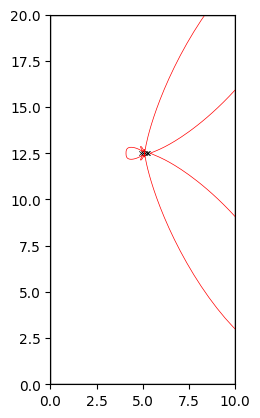

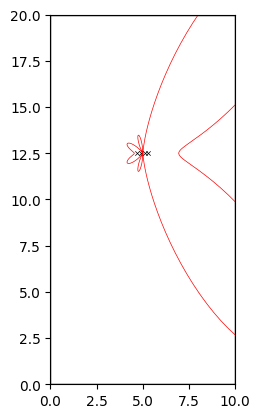

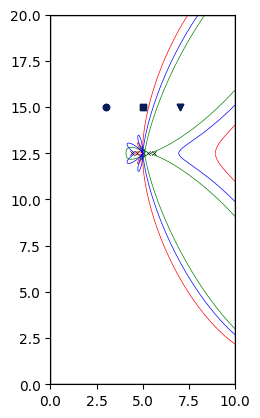

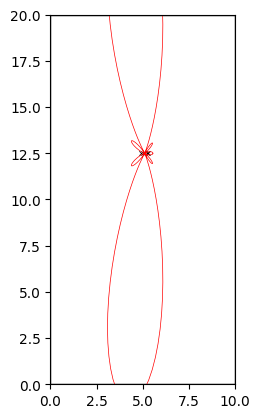

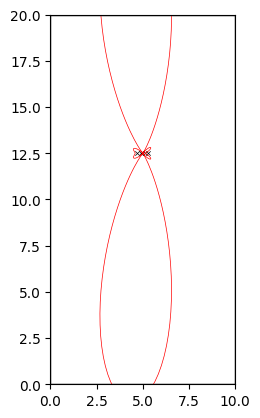

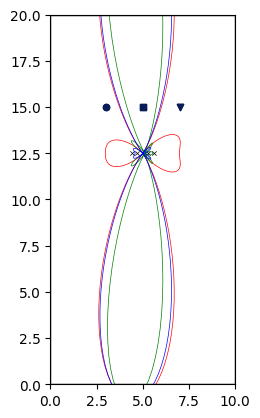

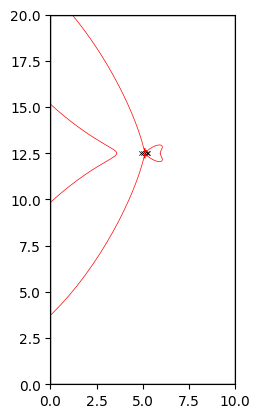

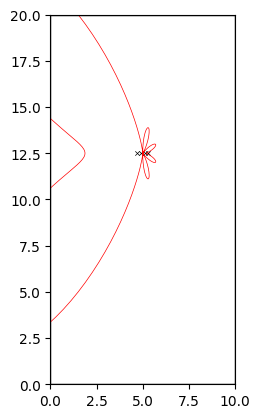

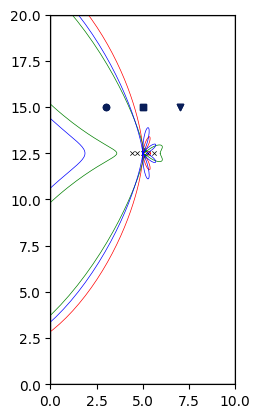

In [87]:
rooms = [pra.ShoeBox([room_x, room_y], fs=fs, materials=m, max_order=order, air_absorption=True, ray_tracing=False) for i in range(3)]
source_locs = [[3, 15], [5, 15], [7, 15]] # locations of each source in 3D space (can modify)
source_inputs = ['../input_samples/singing_8000.wav', '../input_samples/german_speech_8000.wav', '../input_samples/cmu_arctic_us_aew_a0001.wav'] # filepaths to wav files being played by the source
azimuths = []

for i in range(len(source_locs)):
    rate, audio = wavfile.read(source_inputs[i])

    # ensure sampling rates of all audio matches
    if rate != fs:
        num_samples = int(len(audio) * fs / rate)
        audio = resample(audio, num_samples)
    for k in range(len(rooms)):
        rooms[k].add_source(source_locs[i], signal=audio, delay=0)

    # ground truth azimuths for comparison (calculated relative to the x axis)
    azimuths.append(180/np.pi * math.atan2(source_locs[i][1] - array_loc[1], source_locs[i][0] - array_loc[0]))
    
azimuths.sort()
print('Source azimuths:', azimuths)

# DOA estimation
for k in range(len(rooms)):
    rooms[k].add_microphone_array(arrays[k])
    rooms[k].add_source(source_locs[i], signal=audio, delay=0)
    rooms[k].compute_rir()
    rooms[k].simulate()

# short-time fourier transform of signal
X = np.array(
    [
        pra.transform.stft.analysis(signal, N, N // 2).T
        for signal in rooms[0].mic_array.signals
    ]
)

# NormMUSIC algorithm selected, recommended over MUSIC
n_source = 3
doa = pra.doa.normmusic.NormMUSIC(R1, fs, N, c=v_sound, num_src=n_source, mode='far', azimuth=np.linspace(0, 180, 180)*np.pi/180)
doa.locate_sources(X, freq_bins=np.arange(1, N))
doa_azimuths = doa.azimuth_recon
doa_azimuths.sort()
azimuth_errors = [azimuths[i] - doa_azimuths[i] * 180.0/np.pi for i in range(len(azimuths))]

print("Recovered azimuths:", doa_azimuths * 180.0/np.pi, "degrees")
print("Angular Errors:", azimuth_errors, "degrees")

# add guessed locations of sources to room
guess_dist = 5 # guessed distance away from array - choose far distance for precise beam
guess_source_locs = np.empty((2, n_source))

for i in range(n_source):
    guess_source_locs[0, i] = array_loc[0] + guess_dist*np.cos(doa_azimuths[i])
    guess_source_locs[1, i] = array_loc[1] + guess_dist*np.sin(doa_azimuths[i])

# Beamforming algorithm for each source
for i in range(guess_source_locs.shape[1]):
    current_interferers = guess_source_locs
    current_interferers = np.delete(current_interferers, i, 1)

    interf = pra.soundsource.SoundSource([0, 0])
    interf.images = current_interferers

    source = pra.soundsource.SoundSource([0, 0])
    source.images = np.array([[guess_source_locs[0, i]], [guess_source_locs[1, i]]])

    rooms = [pra.ShoeBox([room_x, room_y], fs=fs, materials=m, max_order=order, air_absorption=True, ray_tracing=False) for i in range(3)]

    for k in range(len(rooms)):
        rooms[k].add_microphone_array(arrays[k])

        # define beamformer algorithm and compute weights
        arrays[k].rake_max_sinr_weights(
            source=source,
            interferer=interf,
            R_n=sigma2_n * np.eye(arrays[k].M)
        )

    # compute SIR, averaged across all frequency bands
    SIR_sum = 0
    for f in arrays[0].frequencies[freq_idx1:]:
        current_SIR = arrays[0].snr(source, interf, f, dB=True)
        if math.isnan(current_SIR) == False:
            SIR_sum += current_SIR

    for f in arrays[1].frequencies[freq_idx2:freq_idx1]:
        current_SIR = arrays[1].snr(source, interf, f, dB=True)
        if math.isnan(current_SIR) == False:
            SIR_sum += current_SIR


    for f in arrays[2].frequencies[:freq_idx2]:
        current_SIR = arrays[2].snr(source, interf, f, dB=True)
        if math.isnan(current_SIR) == False:
            SIR_sum += current_SIR

    SIR_avg = SIR_sum / len(array1.frequencies)
    print(f'source {i+1}: average SINR: {SIR_avg:.2f}')
    fig1, ax1 = rooms[0].plot(freq=[1500], plot_directivity=False)
    pattern1 = ax1.lines[0].get_data()
    fig2, ax2 = rooms[1].plot(freq=[750], plot_directivity=False)
    pattern2 = ax2.lines[0].get_data()
    rooms[2].add_source(source_locs[0])
    rooms[2].add_source(source_locs[1])
    rooms[2].add_source(source_locs[2])
    fig3, ax3 = rooms[2].plot(freq=[325], plot_directivity=False)
    ax3.plot(pattern1[0], pattern1[1], 'g-', linewidth = 0.5)
    ax3.plot(pattern2[0], pattern2[1], 'b-', linewidth = 0.5)